<a href="https://colab.research.google.com/github/WuilsonEstacio/python-for-data-science/blob/main/analysis_Aerolineas_americanas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo pivotar y trazar datos con pandas
Un gran desafío de trabajar con datos es manipular su formato para el análisis en cuestión. Para hacer las cosas un poco más difíciles, el "formato adecuado" puede depender de lo que está tratando de analizar, lo que significa que tenemos que saber cómo fundir, pivotar y transponer nuestros datos.


En este artículo, discutiremos cómo crear una tabla dinámica de datos agregados para hacer una visualización de barras apiladas de la participación de mercado de las aerolíneas en 2019 para las 10 principales ciudades de destino. Todo el código para este análisis está disponible en GitHub [here](https://github.com/stefmolin/airline-market-share-analysis) and can also be run using [this](https://mybinder.org/v2/gh/stefmolin/airline-market-share-analysis/master) Binder environment.

Usaremos las estadísticas de vuelo de 2019 de la Oficina de Estadísticas de Transporte del Departamento de Transporte de los Estados Unidos (available [here](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FMF&QO_fu146_anzr=Nv4%20Pn44vr45)). Contiene 321,409 filas y 41 columnas:

In [ ]:
import pandas as pd

df = pd.read_csv('/content/843174595_T_T100_MARKET_ALL_CARRIER.zip')
df.shape

(235605, 41)

Cada fila contiene información agregada mensual sobre vuelos operados por una variedad de aerolíneas, incluidos los servicios de pasajeros y carga. Tenga en cuenta que las columnas están todas en mayúsculas en este momento:

In [ ]:
df.columns

Index(['PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'UNIQUE_CARRIER',
       'AIRLINE_ID', 'UNIQUE_CARRIER_NAME', 'UNIQUE_CARRIER_ENTITY', 'REGION',
       'CARRIER', 'CARRIER_NAME', 'CARRIER_GROUP', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_COUNTRY', 'ORIGIN_COUNTRY_NAME',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_COUNTRY', 'DEST_COUNTRY_NAME',
       'DEST_WAC', 'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 'CLASS',
       'DATA_SOURCE', 'Unnamed: 40'],
      dtype='object')

Para facilitar el trabajo con los datos, transformaremos los nombres de las columnas en minúsculas usando el método  `rename()` method:

In [ ]:
df = df.rename(lambda x: x.lower(), axis=1)
df.head()

,passengers,freight,mail,distance,unique_carrier,airline_id,unique_carrier_name,unique_carrier_entity,region,carrier,carrier_name,carrier_group,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_country,origin_country_name,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_country,dest_country_name,dest_wac,year,quarter,month,distance_group,class,data_source,unnamed: 40
0,0.0,165.0,3641.0,373.0,KO,20341.0,Alaska Central Express,06019,D,KO,Alaska Central Express,1,15991,1599102,35991,YAK,"Yakutat, AK",AK,2.0,Alaska,US,United States,1,10299,1029906,30299,ANC,"Anchorage, AK",AK,2.0,Alaska,US,United States,1,2020,1,1,1,G,DU,NaN
1,0.0,751.0,161.0,557.0,KO,20341.0,Alaska Central Express,06019,D,KO,Alaska Central Express,1,10299,1029906,30299,ANC,"Anchorage, AK",AK,2.0,Alaska,US,United States,1,14738,1473802,34738,SDP,"Sandpoint, AK",AK,2.0,Alaska,US,United States,1,2020,1,1,2,L,DU,NaN
2,0.0,0.0,0.0,385.0,AN,21894.0,"ADVANCED AIR, LLC",01229,D,AN,"ADVANCED AIR, LLC",1,12127,1212702,32575,HHR,"Hawthorne, CA",CA,6.0,California,US,United States,91,15232,1523201,35232,TKF,"Truckee, CA",CA,6.0,California,US,United States,91,2020,1,1,1,F,DU,NaN
3,0.0,0.0,0.0,385.0,AN,21894.0,"ADVANCED AIR, LLC",01229,D,AN,"ADVANCED AIR, LLC",1,15232,1523201,35232,TKF,"Truckee, CA",CA,6.0,California,US,United States,91,12127,1212702,32575,HHR,"Hawthorne, CA",CA,6.0,California,US,United States,91,2020,1,1,1,F,DU,NaN
4,0.0,10362.0,0.0,4620.0,ADB,20110.0,Antonov Company,9488B,I,ADB,Antonov Company,0,15256,1525605,35256,TLS,"Toulouse, France",NaN,NaN,NaN,FR,France,427,13303,1330303,32467,MIA,"Miami, FL",FL,12.0,Florida,US,United States,33,2020,1,2,10,P,IF,NaN


Para nuestro análisis, queremos observar las aerolíneas de pasajeros para encontrar la participación de mercado en 2020 de las 5 principales aerolíneas (según el número total de pasajeros en 2020). Para hacerlo, primero debemos averiguar qué aerolíneas estaban entre las cinco primeras. Recuerde, los datos contienen información sobre todos los tipos de vuelos, pero solo queremos vuelos de pasajeros, por lo que primero consultamos "df" para los vuelos marcados con "F". en la columna `class` (tenga en cuenta que necesitamos comillas invertidas para hacer referencia a esta columna porque` class` es una palabra clave reservada). Luego, agrupamos por el nombre del transportista y sumamos los recuentos de pasajeros de cada transportista. Finalmente, llamamos al método `nlargest ()` para devolver solo los 5 primeros:

In [ ]:
# download flight class meanings at  query es una pregunta o consulta
# https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_fReiVPR_PYNff 
top_airlines = df.query('`class` == "F"')\
    .groupby('unique_carrier_name').passengers.sum()\
    .nlargest(5)
top_airlines

unique_carrier_name
Southwest Airlines Co.    67785236.0
American Airlines Inc.    65745807.0
Delta Air Lines Inc.      55021728.0
United Air Lines Inc.     37844981.0
SkyWest Airlines Inc.     20315801.0
Name: passengers, dtype: float64

Tenga en cuenta que las 5 principales aerolíneas también realizan vuelos de una clase diferente, por lo que no podemos eliminar este filtro durante el resto de nuestro análisis:

In [ ]:
df.loc[
    df.unique_carrier_name.isin(top_airlines.index), 'class'
].value_counts()

F    71380
L     2500
P      927
Name: class, dtype: int64


Ahora, podemos crear la tabla dinámica; sin embargo, no podemos filtrar hasta las 5 principales aerolíneas por el momento, porque, para obtener participación de mercado, también necesitamos conocer las cifras de las otras aerolíneas. Por lo tanto, crearemos una tabla dinámica que calcula el número total de pasajeros que cada aerolínea voló a cada ciudad de destino. Para hacerlo, especificamos que queremos lo siguiente en nuestra llamada al método `pivot_table()` :

Los valores únicos en la columna `dest_city_name` deben usarse como nuestras etiquetas de fila (el argumento de índice)
Los valores únicos en la columna `unique_carrier_name` deben usarse como nuestras etiquetas de columna (el argumento de las columnas  `columns`)
Los valores utilizados para la agregación deben provenir de la columna de `passengers`(el argumento de valores) y deben sumarse (el argumento de `aggfunc`)
Deben calcularse los subtotales de fila / columna (el argumento de los `margins`)

Finalmente, dado que queremos ver los 10 destinos principales, ordenaremos los datos en orden descendente usando la columna `All` , que contiene el total de pasajeros volados a cada ciudad en 2019 para todos los transportistas combinados (esto se creó pasando en `margins=True` en la llamada al método `pivot_table()` ):

In [ ]:
pivot = df.query('`class` == "F"').pivot_table(
    index='dest_city_name', 
    columns='unique_carrier_name', 
    values='passengers',
    aggfunc='sum', 
    margins=True
).sort_values('All', ascending=False)
pivot.head(10)

unique_carrier_name,40-Mile Air,ABC Aerolineas SA de CV dba Interjet,"ADVANCED AIR, LLC",Aer Lingus Plc,"Aeroenlaces Nacionales, S.A. de C.V. d/b/a VivaAerobus",Aeroflot Russian Airlines,Aerolineas Argentinas,Aerolitoral,Aeromexico,Aerovias Nacl De Colombia,Air Asia X Berhad dba Airasia X,Air Canada,Air Canada rouge LP,"Air Charter, Inc d/b/a Air Flamenco",Air China,Air Europa,Air Excursions LLC,Air Georgian,Air New Zealand,Air Pacific Ltd.,Air Serbia,Air Sunshine Inc.,Air Tahiti Nui,Air Transat,Air Wisconsin Airlines Corp,Airitaly S.P.A.,Alaska Airlines Inc.,Alia-(The) Royal Jordanian,All Nippon Airways Co.,Allegiant Air,American Airlines Inc.,Asiana Airlines Inc.,Austrian Airlines,Azerbaijan Airlines CJSC,Azul Linhas Aereas Brazileiras S A,Bahamasair Holding Limited,Beijing Capital Airlines,Bemidji Airlines,Bering Air Inc.,"Bidzy Ta Hot Aana, Inc. d/b/a Tanana Air Service",...,Smokey Bay Air Inc.,South African Airways,"Southern Airways Express, dba Mokulele Airlines",Southwest Airlines Co.,Spernak Airways Inc.,Spirit Air Lines,Star Marianas Air Inc.,Sun Country Airlines d/b/a MN Airlines,Sunwing Airlines Inc.,Surinam Airways Limited,Swiss International Airlines,TUI Airlines Nederland B.V.,Taca International Airlines,Taca Peru,Talofa Airways Limited,Tantalus Air Ltd. d/b/a Harbour Air d/b/a Harbour Air Seaplanes,Tap-Portuguese Airlines,Tatonduk Outfitters Limited d/b/a Everts Air Alaska and Everts Air Cargo,Tradewind Aviation,Trans States Airlines,Transportes Aereos De Cabo,Transportes Aeros Meridiona,Tropic Ocean Airways LLC,Turk Hava Yollari A.O.,Ukraine International Airlines,United Air Lines Inc.,Uzbekistan Airways,VRG Linhas Aereas S A,Venture Travel LLC d/b/a Taquan Air Service,Vieques Air Link Inc.,Virgin Atlantic Airways,Virgin Blue International Airlines t/a V Australia,"Vuela Aviacion, S.A.",WAMOS AIR SA,Warbelow,Westjet,Wright Air Service,"Xiamen Airlines Co., Ltd.",ZIPAIR Tokyo Inc.,All
dest_city_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
All,443.0,182848.0,12323.0,421021.0,373900.0,186190.0,103089.0,252013.0,825652.0,453550.0,40532.0,845296.0,1084342.0,7674.0,161846.0,46601.0,3435.0,5181.0,273394.0,49306.0,42032.0,4097.0,58982.0,123145.0,1443108.0,31163.0,12181493.0,68826.0,525525.0,8639730.0,65745807.0,405984.0,107100.0,4214.0,166270.0,58923.0,3893.0,0.0,48836.0,2849.0,...,6166.0,57539.0,101317.0,67785236.0,89.0,18310384.0,41279.0,1594173.0,49719.0,7055.0,325210.0,10642.0,460423.0,32710.0,2637.0,170.0,256008.0,2696.0,23400.0,597534.0,4911.0,318827.0,2450.0,851929.0,23652.0,37844981.0,16527.0,51960.0,2231.0,49681.0,675093.0,110445.0,44259.0,3757.0,2296.0,1263419.0,36133.0,49588.0,198.0,397965970.0
"Atlanta, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454.0,NaN,34574.0,NaN,NaN,NaN,574481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2009423.0,NaN,873806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23052.0,NaN,206465.0,NaN,NaN,NaN,NaN,22874.0,NaN,NaN,NaN,NaN,12679.0,NaN,NaN,NaN,20630868.0
"Chicago, IL",NaN,14308.0,NaN,32430.0,15644.0,NaN,NaN,NaN,71005.0,NaN,NaN,873.0,NaN,NaN,NaN,NaN,NaN,NaN,8576.0,NaN,NaN,NaN,NaN,NaN,474908.0,NaN,174528.0,20813.0,43632.0,12691.0,3456950.0,NaN,13835.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4033215.0,NaN,836349.0,NaN,8657.0,NaN,NaN,18751.0,NaN,NaN,NaN,NaN,NaN,10261.0,NaN,NaN,83543.0,NaN,NaN,NaN,65645.0,NaN,3860361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18974199.0
"Dallas/Fort Worth, TX",NaN,8067.0,NaN,NaN,8550.0,NaN,NaN,4954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93875.0,NaN,NaN,NaN,12090024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7569.0,NaN,NaN,730389.0,NaN,39266.0,NaN,NaN,NaN,NaN,7988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,NaN,NaN,228726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18670106.0
"Denver, CO",NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,21542.0,NaN,NaN,11358.0,NaN,NaN,NaN,

Observe que la primera fila del resultado anterior no es una ciudad, sino el subtotal por aerolínea, por lo que eliminaremos esa fila antes de seleccionar las primeras 10 filas de los datos ordenados:

In [ ]:
pivot = pivot.drop('All').head(10)

Al seleccionar las columnas para las 5 principales aerolíneas, ahora nos da la cantidad de pasajeros que cada aerolínea voló a las 10 principales ciudades. Tenga en cuenta que usamos `sort_index()` para que las columnas resultantes se muestren en orden alfabético:

In [ ]:
pivot[top_airlines.sort_index().index]

unique_carrier_name,American Airlines Inc.,Delta Air Lines Inc.,SkyWest Airlines Inc.,Southwest Airlines Co.,United Air Lines Inc.
dest_city_name,,,,,
"Atlanta, GA",574481.0,14187295.0,249051.0,2009423.0,206465.0
"Chicago, IL",3456950.0,464399.0,1353800.0,4033215.0,3860361.0
"Dallas/Fort Worth, TX",12090024.0,499963.0,667059.0,NaN,228726.0
"Denver, CO",816616.0,667741.0,1822720.0,4967272.0,4598692.0
"Los Angeles, CA",2584339.0,2227480.0,825664.0,1617108.0,1597527.0
"Charlotte, NC",7788090.0,212535.0,33836.0,137870.0,28238.0
"New York, NY",1639089.0,3144952.0,70967.0,445400.0,229711.0
"Houston, TX",389067.0,305901.0,502854.0,2950480.0,4182073.0
"Phoenix, AZ",3760759.0,680548.0,581993.0,3514159.0,464329.0


Nuestros datos ahora están en el formato correcto para un diagrama de barras apiladas que muestra el recuento de pasajeros. Para hacer esta visualización, llamamos al método `plot ()` en el resultado anterior y especificamos que queremos barras horizontales (`kind = 'barh'`) y que las diferentes aerolíneas deben apilarse (` stacked = True`). Tenga en cuenta que dado que tenemos los destinos ordenados en orden descendente, Atlanta se trazará en la parte inferior, por lo que llamamos `invert_yaxis ()` en el objeto `Axes` devuelto por` plot () `para cambiar el orden:

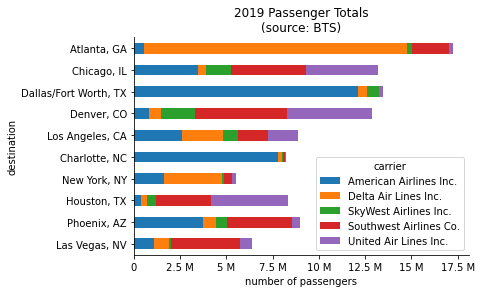

In [ ]:
from matplotlib import ticker

ax = pivot[top_airlines.sort_index().index].plot(
    kind='barh', stacked=True, 
    title='2019 Passenger Totals\n(source: BTS)'
)
ax.invert_yaxis() # put destinations with more passengers on top

# formatting
ax.set(xlabel='number of passengers', ylabel='destination')
ax.legend(title='carrier')

# shows x-axis in millions instead of scientific notation
ax.xaxis.set_major_formatter(ticker.EngFormatter())

# removes the top and right lines from the figure to make it less boxy
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

Una cosa interesante a tener en cuenta del resultado anterior es que Seattle es uno de los 10 destinos principales, sin embargo, las 5 principales aerolíneas no parecen estar contribuyendo tanto como el resto de las ciudades de destino, que están prácticamente en el mismo orden. con la excepción de Los Ángeles. Esto podría causar cierta confusión, así que agreguemos otra barra apilada llamada `Other` que contiene los totales de pasajeros para todas las aerolíneas que no están en el top 5. Como calculamos la columna `All`  cuando creamos la tabla dinámica, todo lo que tenemos que hacer Lo que debe hacer aquí es agregar una columna a nuestros datos filtrados que contenga la columna `All`  menos los totales de pasajeros de las 5 principales aerolíneas sumados. El código de trazado solo necesita modificarse para desplazar la leyenda más lejos: 

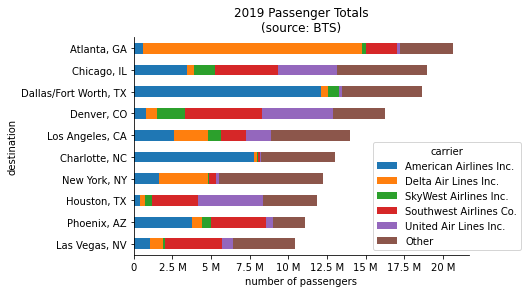

In [ ]:
ax = pivot[top_airlines.sort_index().index].assign(
    Other=lambda x: pivot.All - x.sum(axis=1)
).plot(
    kind='barh', stacked=True, 
    title='2019 Passenger Totals\n(source: BTS)'
)
ax.invert_yaxis()

# formatting
ax.set(xlabel='number of passengers', ylabel='destination')
ax.xaxis.set_major_formatter(ticker.EngFormatter())

# shift legend to not cover the bars
ax.legend(title='carrier', bbox_to_anchor=(0.7, 0), loc='lower left')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

Ahora podemos ver claramente que Atlanta tuvo la mayor cantidad de pasajeros que llegaron en 2019 y que los vuelos de Delta Air Lines fueron los que más contribuyeron. Pero podemos hacerlo mejor si representamos la participación de mercado como el porcentaje de todos los pasajeros que llegan a cada ciudad de destino. Para hacer eso, necesitamos modificar nuestra tabla dinámica dividiendo los recuentos de pasajeros de cada aerolínea por la columna `All`:

In [ ]:
normalized_pivot = \
    pivot[top_airlines.sort_index().index].apply(lambda x: x / pivot.All)
normalized_pivot

unique_carrier_name,American Airlines Inc.,Delta Air Lines Inc.,SkyWest Airlines Inc.,Southwest Airlines Co.,United Air Lines Inc.
dest_city_name,,,,,
"Atlanta, GA",0.027846,0.687673,0.012072,0.097399,0.010008
"Chicago, IL",0.182192,0.024475,0.071350,0.212563,0.203453
"Dallas/Fort Worth, TX",0.647561,0.026779,0.035729,NaN,0.012251
"Denver, CO",0.050211,0.041057,0.112073,0.305422,0.282759
"Los Angeles, CA",0.185168,0.159599,0.059159,0.115866,0.114463
"Charlotte, NC",0.598988,0.016346,0.002602,0.010604,0.002172
"New York, NY",0.133946,0.257004,0.005799,0.036398,0.018772
"Houston, TX",0.032806,0.025794,0.042401,0.248786,0.352634
"Phoenix, AZ",0.339175,0.061377,0.052489,0.316935,0.041877


Antes de graficar, también ordenaremos las barras por la participación de mercado total de los 5 principales operadores. Ver esta información como porcentajes nos da una mejor idea de qué aerolíneas dominan qué mercados: Delta tiene, con mucho, la mayor participación de Atlanta y American Airlines tiene más del 60% de Dallas / Fort Worth, mientras que United tiene una sólida presencia en varios mercados:

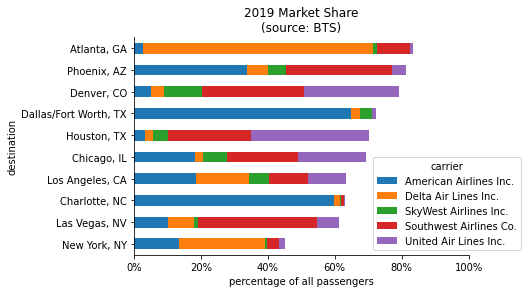

In [ ]:
# determine sort order
market_share_sorted = normalized_pivot.sum(axis=1).sort_values()

ax = normalized_pivot.loc[market_share_sorted.index,:].plot(
    kind='barh', stacked=True, xlim=(0, 1), 
    title='2019 Market Share\n(source: BTS)'
)

# formatting
ax.set(xlabel='percentage of all passengers', ylabel='destination')
ax.legend(title='carrier', bbox_to_anchor=(0.7, 0), loc='lower left')

# show x-axis as percentages
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

Como notamos anteriormente, Seattle sobresale. Las 5 principales aerolíneas tienen más del 50% de participación de mercado combinada para 9 de los 10 destinos principales, pero no para Seattle. Usando nuestra tabla dinámica, podemos ver que Alaska Airlines es la principal aerolínea para Seattle:

Now, it's your turn.

In this article, we explored just a few of the many powerful features in the `pandas` library that make data analysis easier. While we only used a small subset of the columns, this dataset is packed with information that can be analyzed using a pivot table: try looking into origin cities, freight/mail carriers, or even flight distance.

Be sure to check out my upcoming ODSC Europe 2021 training session, "[Introduction to Data Analysis Using Pandas](https://odsc.com/speakers/introduction-to-data-analysis-using-pandas/)", from 1:30-4:30 PM BST June 10, 2021, for an in-depth introduction to `pandas`. Or pick up my book,  "[Hands-On Data Analysis with Pandas](https://www.amazon.com/Hands-Data-Analysis-Pandas-visualization-dp-1800563450/dp/1800563450/)", for a thorough exploration of the `pandas` library using real-world datasets, along with `matplotlib`, `seaborn`, and `scikit-learn`.